In [1]:
!pip install lingam

In [4]:
#German
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import train_test_split

from csse import CSSE
from prepare_dataset import *

import pickle

import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import print_causal_directions, print_dagc, make_dot

from tqdm import tqdm
import random as rnd

from IPython.display import display

import warnings

warnings.filterwarnings('ignore')

In [61]:
#German
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import train_test_split

from csse import CSSE
from prepare_dataset import *

import pickle

import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import print_causal_directions, print_dagc, make_dot

from tqdm import tqdm
import random as rnd

from IPython.display import display

import warnings

warnings.filterwarnings('ignore')



class CCSSE:
    def __init__(self, dataset, samples = None, K = 5, generation = 10):
        self.dataset = dataset
        self.samples = samples
        self.K = K
        self.generation = generation
        
        self.x_train, self.x_test, self.y_train, self.y_test, self.dfx_full, self.dfy_full = self.get_datasets_train_test()

        self.bb_model, self.p = self.get_bb_model()
        self.explainerCSSE = self.get_model_contrafactual()
        self.model_causal, self.df_causal_effects, self.df_error, self.causal_order = self.get_model_causality()
    
        self.run_dict = {}
        self.run_non_causal_dict = {}
    
    def get_datasets_train_test(self):
        if self.dataset == "german_short":
            map_columns = {
                'Unnamed: 0': 'index',
                'x0': 'Sex',
                'x1': 'Age',
                'x2': 'Credit',
                'x3': 'LoanDuration',
            }
            x_train = pd.read_csv("data/algrec_german/X_train_short.csv").rename(columns = map_columns)
            x_test = pd.read_csv("data/algrec_german/X_test_short.csv").rename(columns = map_columns)
            y_train = pd.read_csv("data/algrec_german/y_train_short.csv").rename(columns={'Unnamed: 0': 'index'})
            y_test = pd.read_csv("data/algrec_german/y_test_short.csv").rename(columns={'Unnamed: 0': 'index'})
            x_train = x_train.set_index('index')
            x_test = x_test.set_index('index')
            y_train = y_train.set_index('index')
            y_test = y_test.set_index('index')
            dfx_full = pd.concat([x_train, x_test])
            dfy_full = pd.concat([y_train, y_test])

        elif self.dataset == "german_medium":
            map_columns = {
                'Unnamed: 0': 'index',
                'x0': 'Sex',
                'x1': 'Age',
                'x2': 'Credit',
                'x3': 'LoanDuration',
                'x4': 'CheckingAccountBalance',
                'x5':'SavingsAccountBalance',
                'x6':'HousingStatus'
            }
            x_train = pd.read_csv("data/algrec_german/X_train.csv").rename(columns = map_columns)
            x_test = pd.read_csv("data/algrec_german/X_train.csv").rename(columns = map_columns)
            y_train = pd.read_csv("data/algrec_german/X_train.csv").rename(columns={'Unnamed: 0': 'index'})
            y_test = pd.read_csv("data/algrec_german/X_train.csv").rename(columns={'Unnamed: 0': 'index'})
            x_train = x_train.set_index('index')
            x_test = x_test.set_index('index')
            y_train = y_train.set_index('index')
            y_test = y_test.set_index('index')
            dfx_full = pd.concat([x_train, x_test])
            dfy_full = pd.concat([y_train, y_test])

        elif self.dataset == "german_full":
            df_main = prepare_german_dataset("german_credit.csv", "data/")
            columns = df_main.columns
            class_name = 'default' # default = 0 = "Good class" / default = 1 = "Bad class" 
            columns_tmp = list(columns)
            columns_tmp.remove(class_name)

            x_train, x_test, y_train, y_test = train_test_split(df_main[columns_tmp], df_main[class_name], test_size=0.1)

            dfx_full = pd.concat([x_train, x_test])
            dfy_full = pd.concat([y_train, y_test])

        else:
            x_train = pd.DataFrame()
            x_test = pd.DataFrame()
            y_train = pd.DataFrame()
            y_test = pd.DataFrame()
            dfx_full = pd.DataFrame()
            dfy_full = pd.DataFrame()

        return x_train, x_test, y_train, y_test, dfx_full, dfy_full
    

    def get_bb_model(self):
        bb_model = RandomForestClassifier(n_estimators = 120, n_jobs=-1, random_state=0)  
        bb_model.fit(self.x_train, self.y_train)

        p = bb_model.predict(self.x_test)

        print(classification_report(self.y_test, p))

        return bb_model, p

    def get_model_contrafactual(self):
        return CSSE(self.dfx_full, self.bb_model, K = self.K, num_gen = self.generation)

    def get_model_causality(self):
        model_causal = lingam.DirectLiNGAM()
        model_causal.fit(self.dfx_full)
            
        labels = [f'{i}' for i in self.dfx_full.columns]
        causal_order = [labels[x] for x in model_causal.causal_order_]
        
        matrix = model_causal.adjacency_matrix_
        from_list = []
        to_list = []
        effect_list = []

        # Iteração sobre a matriz para extrair os valores e suas posições
        for i in range(len(matrix)):
            for j in range(len(matrix[i])):
                if matrix[i][j] != 0:
                    from_list.append(j)
                    to_list.append(i)
                    effect_list.append(matrix[i][j])

        # Criando o DataFrame
        df_causal_effects = pd.DataFrame({'from': from_list, 'to': to_list, 'effect': effect_list})
        labels = [f'{i}' for i in self.dfx_full.columns]
        df_causal_effects['from'] = df_causal_effects['from'].apply(lambda x : labels[x])
        df_causal_effects['to'] = df_causal_effects['to'].apply(lambda x : labels[x])


        matrix_error = model_causal.get_error_independence_p_values(self.dfx_full)
        from_list = []
        to_list = []
        effect_list = []

        # Iteração sobre a matriz para extrair os valores e suas posições
        for i in range(len(matrix_error)):
            for j in range(i + 1, len(matrix_error[i])):
                if matrix_error[i][j] != 0:
                    from_list.append(j)
                    to_list.append(i)
                    effect_list.append(matrix_error[i][j])

        # Criando o DataFrame
        df_error = pd.DataFrame({'from': from_list, 'to': to_list, 'effect': effect_list})
        labels = [f'{i}' for i in self.dfx_full.columns]
        df_error['from'] = df_error['from'].apply(lambda x : labels[x])
        df_error['to'] = df_error['to'].apply(lambda x : labels[x])
        

        return model_causal, df_causal_effects, df_error, causal_order
        
    
    def print_causal_graph(self):
        make_dot(self.model_causal.adjacency_matrix_)

    def run_non_causal(self):
        self.run_non_causal_dict = {}

        if isinstance(self.samples, list):
            self.create_run_dict(self)
            for sample in self.samples:
                self.run_non_causal_sample(sample)
                
        elif isinstance(self.samples, int):
            for sample in range(self.samples):
                self.run_non_causal_sample(sample)
        
        else: 
            for sample in range(10):
                self.run_non_causal_sample(sample)
                
    def run_non_causal_sample(self, sample):
        self.run_non_causal_dict[sample] = {}
        original_instance = self.x_test.iloc[sample].copy()
        contrafactual_set, solution = self.explainerCSSE.explain(original_instance, self.p[sample]) #Method returns the list of counterfactuals and the explanations generated from them

        self.run_non_causal_dict[sample]['solution'] = solution

    def run_causal(self):
        self.run_dict = {}
        self.run_dict['global_numbers'] = {
                    "global_quant_changes": 0,
                    "global_quant_causal_changes": 0,
                    "global_quant_causal_rules": 0,
                    "global_quant_zeros_causal": 0,
                    "global_quant_full_causal": 0,
                    "global_quant_causal_contrafac": 0,
                    "global_quant_maioria_causal_satisfeita": 0,
                    "global_quant_contrafac_unico": 0
            }
        self.global_quant_contrafac_max = 0
        if isinstance(self.samples, list):
            self.create_run_dict(self)
            for sample in self.samples:
                self.run_causal_sample(sample)
                
        elif isinstance(self.samples, int):
            for sample in range(self.samples):
                self.run_causal_sample(sample)
        
        else: 
            for sample in range(10):
                self.run_causal_sample(sample)
        
        self.global_quant_contrafac_max = self.K * len(self.run_dict)


    def run_causal_sample(self, sample):
        original_instance = self.x_test.iloc[sample]
        self.run_dict[sample] = {}
        self.run_dict[sample]['original_instance'] = original_instance

        print(f'Running original instance:\n {display(original_instance)}')

        causal_explain = self.get_causal_explain(sample)
        self.run_dict[sample]['causal_explain'] = causal_explain

        list_analyse = []
        for contrafactual in causal_explain[0]:
            list_analyse.append(self.analyse_contrafac(contrafactual, causal_explain[1], causal_explain[2]))

        self.run_dict[sample]['list_analyse'] = list_analyse
        self.analyse_explaination(sample)

    def analyse_contrafac(self, contrafac, df, original_ind):
        columns = [x.column for x in contrafac]
        condicao = (df['to'].isin(columns)) & (df['from'].isin(columns))
        ind = original_ind[columns]
        return [contrafac, df[condicao], ind]

    def get_causal_explain(self, sample):
        original_ind = self.x_test.iloc[sample].copy() #Original instance
        #self.ind_cur_class = ind_cur_class #Index in the shap corresponds to the original instance class
        self.explainerCSSE.current_class = self.p[sample] #Original instance class
        self.explainerCSSE.original_ind = original_ind
        
        ind_cur_class = self.explainerCSSE.getBadClass()

        #Gets the valid values range of each feature
        features_range = []
        features_range = self.explainerCSSE.getFeaturesRange()

        #The DataFrame df will have the current population
        df = pd.DataFrame(columns=self.explainerCSSE.input_dataset.columns)

        #Generates the initial population with popinitial mutants        
        self.explainerCSSE.getPopInicial(df, features_range)
        df_causal = df.copy()
        dict_dfs = {}

        # for g in tqdm(range(self.explainerCSSE.num_gen), desc= "Processing..."):
        for g in tqdm(range(self.generation), desc= "Processing..."):

            #To use on the parents of each generation
            old_parents = pd.DataFrame(columns=self.explainerCSSE.input_dataset.columns)

            #Copy parents to the next generation
            old_parents = df_causal.copy()
            dict_dfs[g] = {}

            parents_causal = self.apply_causality(old_parents)
            dict_dfs[g]['causal_parents'] = parents_causal
            #df will contain the new population
            df_causal = pd.DataFrame(columns=self.explainerCSSE.input_dataset.columns)
            evaluation_causal = []

            #Assessing generation counterfactuals
            self.explainerCSSE.fitness(dict_dfs[g]['causal_parents'], evaluation_causal, ind_cur_class)

            #The original individual will always be in the 0 position of the df - So that it is normalized too (it will be used later in the distance function)
            df_causal.loc[0] = original_ind.copy()

            #Copies to the next generation the per_elit best individuals
            self.explainerCSSE.elitism(evaluation_causal, df_causal, parents_causal)
            number_cross_repetitions = 0
            while len(df_causal) < self.explainerCSSE.pop_size + 1: #+1, as the 1st position is used to store the reference individual
                number_cross_repetitions_causal = self.explainerCSSE.crossover(df_causal, parents_causal, evaluation_causal, number_cross_repetitions)

                mutation_op = rnd.random()
                if mutation_op <= self.explainerCSSE.mutation_proba:
                    self.explainerCSSE.mutation(df_causal, len(df_causal) - 1, features_range)


        evaluation = []
        evaluation_causal = []

        #Evaluating the latest generation
        self.explainerCSSE.fitness(df_causal, evaluation_causal, ind_cur_class)

        #Order the last generation by distance to the original instance     
        evaluation_causal.sort(key=lambda individual: individual.aval_norm) 

        #Getting the counterfactual CAUSAL set
        contrafactual_set_causal, solution_list_causal = self.explainerCSSE.getContrafactual(df_causal, evaluation_causal) 

        dict_dfs['contrafactual_set_causal'] = contrafactual_set_causal
        dict_dfs['solution_list_causal'] = solution_list_causal
        
        df_contrafac_causal = self.get_contrafac_df_causal(solution_list_causal)
        return [solution_list_causal, df_contrafac_causal, original_ind]
    

    def apply_causality(self, df):
        df_apply_causal = pd.DataFrame(columns = df.columns)
        original = df.iloc[0]
        df_apply_causal.loc[0] = original
        for index, df_row in df.iloc[1:].iterrows():
            causal_ind = df_row.copy()
            for column in self.causal_order:
                value_diff = causal_ind[column] - original[column]
                if value_diff != 0:
                    tmp_effects = self.df_causal_effects[self.df_causal_effects['from'] == column]
                    for index, row in tmp_effects.iterrows():
    #                     prob = rnd.random()
    #                     if row['probability'] <= prob:
                        tmp_error = self.df_error[self.df_error['from'].isin([column, row['to']]) | self.df_error['to'].isin([column, row['to']])]
                        error_value = tmp_error['effect'].iloc[0]
    #                     print(f'error value = {error_value}')
                        causal_ind[row['to']] = causal_ind[row['to']] + (value_diff * row['effect']) + tmp_error['effect'].iloc[0]
            df_apply_causal.loc[len(df_apply_causal)] = causal_ind
        return df_apply_causal


    def get_contrafac_df_causal(self, solution_list_causal):
        lista_solution_causal = [[t.column for t in sublist] for sublist in solution_list_causal]

        # Inicializa uma lista para armazenar os resultados
        resultados = []

        # Loop sobre os valores na lista
        for lista_valores in lista_solution_causal:
            if len(lista_valores) > 1:
                for v1 in lista_valores:
                    for v2 in lista_valores:
                        if v1 != v2:
                            # Cria uma condição para cada par de valores diferentes na lista
                            condicao = (self.df_causal_effects['to'].isin([v1, v2])) & (self.df_causal_effects['from'].isin([v1, v2]))
                            # Realiza a busca no DataFrame usando a condição e armazena os resultados
                            resultados.append(self.df_causal_effects[condicao])

        # Concatena os resultados em um único DataFrame
        if resultados:
            resultado_final = pd.concat(resultados)
            resultado_final = resultado_final.drop_duplicates()
        else:
            resultado_final = pd.DataFrame(columns = self.df_causal_effects.columns)
            
        return resultado_final
    

    def analyse_explaination(self, sample):
        self.run_dict[sample]['data_analysis'] = []
        for i, content in enumerate(self.run_dict[sample]['list_analyse']):
            self.global_quant_contrafac_max += 1
            controle = {}
            causal = content[0]
            df = content[1]
            ori = content[2]
            
            
            num_changes = len(causal)
            self.run_dict['global_numbers']['global_quant_changes'] += num_changes
            
            num_causal_rules = len(df)
            self.run_dict['global_numbers']['global_quant_causal_rules'] += num_causal_rules
            
            for attr in causal:
                key = attr.column
                if attr.value > ori[key]:
                    controle[key] = 'mais'
                else:
                    controle[key] = 'menos'

            df_temp = df.copy()
            df_temp['from'] = df['from'].map(controle)
            df_temp['to'] = df['to'].map(controle)
            df_temp['causal'] = df_temp.apply(self.verificar_condicoes, axis = 1)
            data_dict = {}

            data_dict['df_respeita_causal'] = df_temp
            data_dict['contrafactual_causal'] = causal
            data_dict['df_causal_effects'] = df
            
            self.run_dict[sample]['data_analysis'].append(data_dict)


            causal_finds = df_temp['causal'].sum()
            self.run_dict['global_numbers']['global_quant_causal_changes'] += causal_finds
            
            # print(f'causal = \n{causal}\n')
            # print(f'original = \n{ori}\n')
            # print(f'df_temp = \n{display(df_temp)}\n')
            
            if len(df_temp) > 0:
                if causal_finds > 0:
                    self.run_dict['global_numbers']['global_quant_causal_contrafac'] += 1
                else:
                    # print(f'nenhuma relaçao causal satisfeita')
                    self.run_dict['global_numbers']['global_quant_zeros_causal'] += 1
    #                 display(df_temp)
    #                 print(f"original = {ori}")
    #                 print(f"causal = {causal}")

                if causal_finds == num_causal_rules:
                    self.run_dict['global_numbers']['global_quant_full_causal'] += 1
                    # if causal_finds > 2:
                        # print(f'todas > 2 relaçoes causais satisfeitas')
    #                     display(df_temp)
    #                     print(f"original = {ori}")
    #                     print(f"causal = {causal}")
                    # elif causal_finds == 1:
                        # print(f'todas = 1 relaçoes causais satisfeitas')
                
                if causal_finds >= (len(df_temp)/2):
                    self.run_dict['global_numbers']['global_quant_maioria_causal_satisfeita'] += 1
            else:
    #             if len(causal) > 0:
                self.run_dict['global_numbers']['global_quant_contrafac_unico'] += 1
        
    def verificar_condicoes(self, row):
        if (row['from'] == 'mais' and row['to'] == 'mais' and row['effect'] > 0):
            return True
        elif row['from'] == 'menos' and row['to'] == 'menos' and row['effect'] > 0:
            return True
        elif row['from'] == 'mais' and row['to'] == 'menos' and row['effect'] < 0:
            return True
        elif row['from'] == 'menos' and row['to'] == 'mais' and row['effect'] < 0:
            return True
        else:
            return False
            

    def show_metrics(self):
        
        for i, sample in self.run_dict.items():
            print(f"quantas instancias contrafactuais encontradas = {self.global_quant_contrafac_max}")
            print(f"quantidade de mudanças totais = {self.run_dict['global_numbers']['global_quant_changes']}")

            print(f"quantas instancias tiveram pelo menos uma relação causal satisfeita = {self.run_dict['global_numbers']['global_quant_causal_contrafac']}/{self.run_dict['global_numbers']['quant_contrafac']}")

            print(f"quantas relações causais foram encontradas = {self.run_dict['global_numbers']['global_quant_causal_rules']}")

            print(f"quantas relações causais foram satisfeitas = {self.run_dict['global_numbers']['global_quant_causal_changes']}/{self.run_dict['global_numbers']['global_quant_causal_rules']}")

            print(f"quantas instâncias não tiveram nenhuma relação causal satisfeita = {self.run_dict['global_numbers']['global_quant_zeros_causal']}/{self.run_dict['global_numbers']['quant_contrafac']}")
            print(f"quantas instâncias tiveram TODAS as relaçoes causais satisfeitas = {self.run_dict['global_numbers']['global_quant_full_causal']}/{self.run_dict['global_numbers']['global_quant_causal_contrafac']}")

            print(f"quantas instancias causais teveram a maioria das relacoes causais satisfeitas = {self.run_dict['global_numbers']['global_quant_maioria_causal_satisfeita']}/{self.run_dict['global_numbers']['quant_contrafac']}")
            print(f"quantas instancias tiveram um unico atributo modificado = {self.run_dict['global_numbers']['global_quant_contrafac_unico']}/{self.run_dict['global_numbers']['quant_contrafac']}")


        

In [64]:
ccsse_s = CCSSE('german_short', samples = 20, K = 10, generation= 30)

              precision    recall  f1-score   support

         0.0       0.43      0.58      0.49        66
         1.0       0.54      0.39      0.46        84

    accuracy                           0.47       150
   macro avg       0.48      0.48      0.47       150
weighted avg       0.49      0.47      0.47       150



In [63]:
ccsse_s.run_causal()

Sex                0.0
Age               37.0
Credit          1274.0
LoanDuration      12.0
Name: 747, dtype: float64

Running original instance:
 None


Processing...:  33%|███▎      | 10/30 [00:14<00:29,  1.46s/it]


KeyboardInterrupt: 

In [65]:
ccsse_m = CCSSE('german_medium', samples = 20, K = 10, generation= 30)

ValueError: multiclass-multioutput is not supported

In [66]:
ccsse_f = CCSSE('german_full', samples = 20, K = 10, generation= 30)

              precision    recall  f1-score   support

           0       0.76      0.94      0.84        68
           1       0.75      0.38      0.50        32

    accuracy                           0.76       100
   macro avg       0.76      0.66      0.67       100
weighted avg       0.76      0.76      0.73       100



In [34]:
ccsse.run_dict[0]['data_analysis']

[{'df_respeita_causal': Empty DataFrame
  Columns: [from, to, effect, causal]
  Index: [],
  'contrafactual_causal': [('Credit', 1500.65)],
  'df_causal_effects': Empty DataFrame
  Columns: [from, to, effect]
  Index: []},
 {'df_respeita_causal': Empty DataFrame
  Columns: [from, to, effect, causal]
  Index: [],
  'contrafactual_causal': [('Age', 43.38)],
  'df_causal_effects': Empty DataFrame
  Columns: [from, to, effect]
  Index: []},
 {'df_respeita_causal':    from    to    effect  causal
  1  mais  mais  142.2142    True,
  'contrafactual_causal': [('Credit', 1399.3696698793983),
   ('LoanDuration', 12.44)],
  'df_causal_effects':            from      to    effect
  1  LoanDuration  Credit  142.2142},
 {'df_respeita_causal': Empty DataFrame
  Columns: [from, to, effect, causal]
  Index: [],
  'contrafactual_causal': [('Age', 38.02), ('Credit', 1309.6641368817313)],
  'df_causal_effects': Empty DataFrame
  Columns: [from, to, effect]
  Index: []}]

In [58]:
ccsse.run_dict[2]['original_instance']

Sex                1.0
Age               25.0
Credit          1264.0
LoanDuration      15.0
Name: 979, dtype: float64

In [51]:
ccsse.run_dict[6]['data_analysis']

[{'df_respeita_causal': Empty DataFrame
  Columns: [from, to, effect, causal]
  Index: [],
  'contrafactual_causal': [('Age', 34.08906015157162)],
  'df_causal_effects': Empty DataFrame
  Columns: [from, to, effect]
  Index: []},
 {'df_respeita_causal': Empty DataFrame
  Columns: [from, to, effect, causal]
  Index: [],
  'contrafactual_causal': [('Credit', 3667.22)],
  'df_causal_effects': Empty DataFrame
  Columns: [from, to, effect]
  Index: []},
 {'df_respeita_causal':     from    to    effect  causal
  1  menos  mais  142.2142   False,
  'contrafactual_causal': [('Credit', 4790.107837867401),
   ('LoanDuration', 20.37)],
  'df_causal_effects':            from      to    effect
  1  LoanDuration  Credit  142.2142},
 {'df_respeita_causal': Empty DataFrame
  Columns: [from, to, effect, causal]
  Index: [],
  'contrafactual_causal': [('Sex', 0.3), ('Credit', 3781.92)],
  'df_causal_effects': Empty DataFrame
  Columns: [from, to, effect]
  Index: []}]

In [55]:
ccsse.run_dict[0]['causal_explain']

[[[('Credit', 1500.65)],
  [('Age', 43.38)],
  [('Credit', 1399.3696698793983), ('LoanDuration', 12.44)],
  [('Age', 38.02), ('Credit', 1309.6641368817313)]],
            from      to    effect
 1  LoanDuration  Credit  142.2142,
 Sex                0.0
 Age               37.0
 Credit          1274.0
 LoanDuration      12.0
 Name: 747, dtype: float64]

In [57]:
ccsse.run_non_causal_dict[2]

{'solution': [[('LoanDuration', 17.08)],
  [('Credit', 1902.81)],
  [('Age', 40.65)],
  [('Sex', 0.5)]]}

In [30]:
ccsse.run_non_causal()

Processing...:  10%|█         | 1/10 [00:01<00:15,  1.72s/it]

Processing...:  20%|██        | 2/10 [00:03<00:12,  1.58s/it]

Processing...:  30%|███       | 3/10 [00:05<00:12,  1.73s/it]

Processing...:  40%|████      | 4/10 [00:07<00:10,  1.81s/it]

Processing...:  50%|█████     | 5/10 [00:08<00:08,  1.69s/it]

Processing...:  60%|██████    | 6/10 [00:10<00:06,  1.71s/it]

Processing...:  70%|███████   | 7/10 [00:11<00:04,  1.66s/it]

Processing...:  80%|████████  | 8/10 [00:13<00:03,  1.59s/it]

Processing...:  90%|█████████ | 9/10 [00:14<00:01,  1.52s/it]

Processing...: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


Processing...:  10%|█         | 1/10 [00:01<00:14,  1.59s/it]

Processing...:  20%|██        | 2/10 [00:03<00:12,  1.60s/it]

Processing...:  30%|███       | 3/10 [00:04<00:09,  1.35s/it]

Processing...:  40%|████      | 4/10 [00:05<00:07,  1.19s/it]

Processing...:  50%|█████     | 5/10 [00:06<00:05,  1.13s/it]

Processing...:  60%|██████    | 6/10 [00:07<00:04,  1.14s/it]

Processing...:  70%|███████   | 7/10 [00:08<00:03,  1.28s/it]

Processing...:  80%|████████  | 8/10 [00:10<00:02,  1.30s/it]

Processing...:  90%|█████████ | 9/10 [00:11<00:01,  1.21s/it]

Processing...: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


Processing...:  10%|█         | 1/10 [00:01<00:10,  1.19s/it]

Processing...:  20%|██        | 2/10 [00:02<00:10,  1.26s/it]

Processing...:  30%|███       | 3/10 [00:03<00:08,  1.23s/it]

Processing...:  40%|████      | 4/10 [00:05<00:07,  1.28s/it]

Processing...:  50%|█████     | 5/10 [00:06<00:06,  1.23s/it]

Processing...:  60%|██████    | 6/10 [00:07<00:05,  1.33s/it]

Processing...:  70%|███████   | 7/10 [00:09<00:04,  1.41s/it]

Processing...:  80%|████████  | 8/10 [00:10<00:02,  1.37s/it]

Processing...:  90%|█████████ | 9/10 [00:11<00:01,  1.27s/it]

Processing...: 100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Processing...:  10%|█         | 1/10 [00:01<00:09,  1.11s/it]

Processing...:  20%|██        | 2/10 [00:02<00:09,  1.17s/it]

Processing...:  30%|███       | 3/10 [00:03<00:07,  1.11s/it]

Processing...:  40%|████      | 4/10 [00:04<00:07,  1.17s/it]

Processing...:  50%|█████     | 5/10 [00:05<00:05,  1.18s/it]

Processing...:  60%|██████    | 6/10 [00:07<00:04,  1.20s/it]

Processing...:  70%|███████   | 7/10 [00:07<00:03,  1.09s/it]

Processing...:  80%|████████  | 8/10 [00:09<00:02,  1.20s/it]

Processing...:  90%|█████████ | 9/10 [00:10<00:01,  1.22s/it]

Processing...: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


Processing...:  10%|█         | 1/10 [00:01<00:13,  1.54s/it]

Processing...:  20%|██        | 2/10 [00:02<00:09,  1.14s/it]

Processing...:  30%|███       | 3/10 [00:03<00:07,  1.05s/it]

Processing...:  40%|████      | 4/10 [00:04<00:07,  1.20s/it]

Processing...:  50%|█████     | 5/10 [00:06<00:06,  1.23s/it]

Processing...:  60%|██████    | 6/10 [00:07<00:05,  1.30s/it]

Processing...:  70%|███████   | 7/10 [00:08<00:04,  1.34s/it]

Processing...:  80%|████████  | 8/10 [00:10<00:02,  1.29s/it]

Processing...:  90%|█████████ | 9/10 [00:11<00:01,  1.34s/it]

Processing...: 100%|██████████| 10/10 [00:13<00:00,  1.33s/it]


Processing...:  10%|█         | 1/10 [00:01<00:09,  1.04s/it]

Processing...:  20%|██        | 2/10 [00:02<00:09,  1.17s/it]

Processing...:  30%|███       | 3/10 [00:04<00:09,  1.41s/it]

Processing...:  40%|████      | 4/10 [00:05<00:08,  1.36s/it]

Processing...:  50%|█████     | 5/10 [00:06<00:06,  1.36s/it]

Processing...:  60%|██████    | 6/10 [00:08<00:05,  1.36s/it]

Processing...:  70%|███████   | 7/10 [00:09<00:03,  1.25s/it]

Processing...:  80%|████████  | 8/10 [00:10<00:02,  1.17s/it]

Processing...: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


Processing...:  10%|█         | 1/10 [00:00<00:08,  1.04it/s]

Processing...:  20%|██        | 2/10 [00:02<00:11,  1.40s/it]

Processing...:  30%|███       | 3/10 [00:04<00:10,  1.44s/it]

Processing...:  40%|████      | 4/10 [00:05<00:07,  1.27s/it]

Processing...:  50%|█████     | 5/10 [00:06<00:06,  1.21s/it]

Processing...:  60%|██████    | 6/10 [00:07<00:04,  1.16s/it]

Processing...:  70%|███████   | 7/10 [00:08<00:03,  1.24s/it]

Processing...:  80%|████████  | 8/10 [00:10<00:02,  1.27s/it]

Processing...:  90%|█████████ | 9/10 [00:11<00:01,  1.33s/it]

Processing...: 100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


Processing...:  10%|█         | 1/10 [00:00<00:08,  1.01it/s]

Processing...:  20%|██        | 2/10 [00:01<00:07,  1.05it/s]

Processing...:  30%|███       | 3/10 [00:03<00:07,  1.02s/it]

Processing...:  40%|████      | 4/10 [00:03<00:06,  1.00s/it]

Processing...:  50%|█████     | 5/10 [00:04<00:04,  1.01it/s]

Processing...:  70%|███████   | 7/10 [00:06<00:02,  1.08it/s]

Processing...:  80%|████████  | 8/10 [00:07<00:01,  1.12it/s]

Processing...:  90%|█████████ | 9/10 [00:08<00:00,  1.07it/s]

Processing...: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Processing...:  10%|█         | 1/10 [00:00<00:08,  1.08it/s]

Processing...:  20%|██        | 2/10 [00:02<00:08,  1.09s/it]

Processing...:  40%|████      | 4/10 [00:04<00:06,  1.01s/it]

Processing...:  50%|█████     | 5/10 [00:05<00:05,  1.04s/it]

Processing...:  60%|██████    | 6/10 [00:06<00:04,  1.14s/it]

Processing...:  70%|███████   | 7/10 [00:07<00:03,  1.15s/it]

Processing...:  80%|████████  | 8/10 [00:08<00:02,  1.12s/it]

Processing...:  90%|█████████ | 9/10 [00:09<00:01,  1.11s/it]

Processing...: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


Processing...:  10%|█         | 1/10 [00:00<00:08,  1.06it/s]

Processing...:  20%|██        | 2/10 [00:01<00:08,  1.01s/it]

Processing...:  40%|████      | 4/10 [00:03<00:05,  1.00it/s]

Processing...:  60%|██████    | 6/10 [00:05<00:03,  1.16it/s]

Processing...:  70%|███████   | 7/10 [00:06<00:02,  1.11it/s]

Processing...:  80%|████████  | 8/10 [00:07<00:01,  1.10it/s]

Processing...:  90%|█████████ | 9/10 [00:08<00:00,  1.11it/s]

Processing...: 100%|██████████| 10/10 [00:09<00:00,  1.02it/s]

In [83]:
print(ccsse.causal_order)

['Sex', 'LoanDuration', 'Credit', 'Age']


In [79]:
ccsse.dfy_full

,y
index,
674,0.0
123,1.0
167,1.0
258,1.0
583,0.0
...,...
539,1.0
803,1.0
540,0.0


In [85]:
ccsse.print_causal_graph()

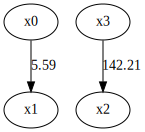

In [86]:
make_dot(ccsse.model_causal.adjacency_matrix_)

In [87]:
print(ccsse.causal_order)

['Sex', 'LoanDuration', 'Credit', 'Age']


In [20]:
ccsse.df_causal_effects

,from,to,effect
0,Sex,Age,5.592995
1,LoanDuration,Credit,142.214200
